Лабораторная работа №6
Проведение исследований с моделями классификации

Загрузка датасета ASL Alphabet

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/asl-alphabet


Библиотеки

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import hamming_loss, f1_score, average_precision_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import random
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Метрики качества модели:
- Hamming Loss - среднее количество misclassifications на случай, то есть количество неправильных классов для каждого примера;

- F1 Score - учитывает как полноту (recall), так и точность (precision), объединяя их в единое значение.

- Mean Average Precision - позволяет оценивать точность предсказаний в каждом классе отдельно, затем усредняя их значение. Лучше показывает точность классификации, если есть аномальные классы (на которых модель сыпется).


Подготовка данных

In [3]:
data_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
Val_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_test'

transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

class_names = dataset.classes
num_classes = len(class_names)
print(class_names)
num_classes = len(dataset.classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [4]:
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

num_train_samples = len(train_dataset)
num_test_samples = len(test_dataset)

print(f'Number of training samples: {num_train_samples}')
print(f'Number of testing samples: {num_test_samples}')

Number of training samples: 69600
Number of testing samples: 17400


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


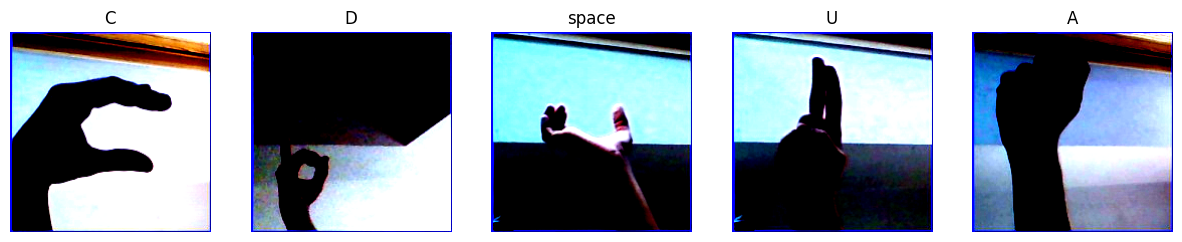

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

def show_random_samples(dataset, class_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        random_idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[random_idx]
        img = img.permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    plt.show()

show_random_samples(train_dataset, class_names)

Обучение модели (ResNet)

In [14]:
model = models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

train_model(model, train_loader, criterion, optimizer)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    accuracy = 100. * correct / total
    h_loss = hamming_loss(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    y_true_binarized = np.zeros((len(all_labels), num_classes))
    y_true_binarized[np.arange(len(all_labels)), all_labels] = 1
    mAP = average_precision_score(y_true_binarized, all_probs)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Hamming Loss: {h_loss:.4f}')
    print(f'F1 Score (Macro): {f1_macro:.4f}')
    print(f'F1 Score (Weighted): {f1_weighted:.4f}')
    print(f'Mean Average Precision (mAP): {mAP:.4f}')

evaluate_model(model, test_loader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2175/2175 [04:57<00:00,  7.32it/s]


Epoch [1/3], Loss: 0.0806, Accuracy: 97.78%


100%|██████████| 2175/2175 [04:52<00:00,  7.44it/s]


Epoch [2/3], Loss: 0.0252, Accuracy: 99.28%


100%|██████████| 2175/2175 [04:55<00:00,  7.36it/s]

Epoch [3/3], Loss: 0.0164, Accuracy: 99.55%


Test Accuracy: 99.54%
Hamming Loss: 0.0046
F1 Score (Macro): 0.9955
F1 Score (Weighted): 0.9954
Mean Average Precision (mAP): 0.9999


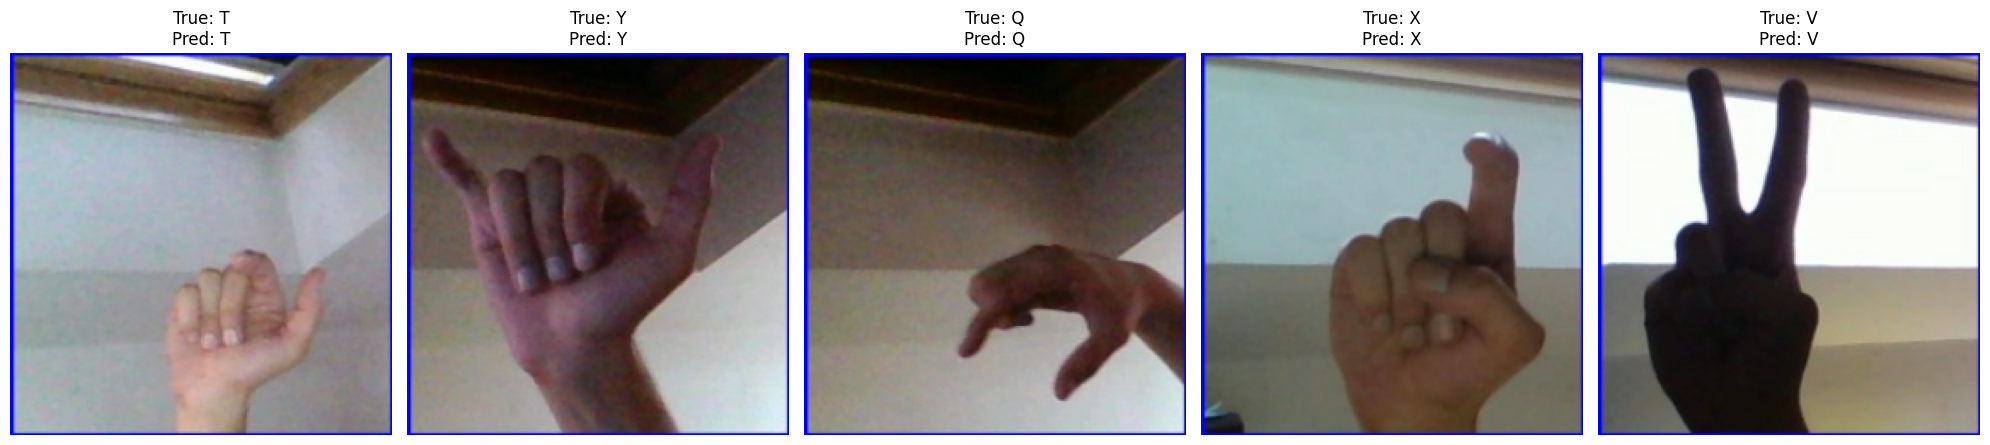

In [17]:
def visualize_predictions(model, test_dataset, class_names, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i in range(num_samples):
        random_idx = random.randint(0, len(test_dataset) - 1)
        img, true_label = test_dataset[random_idx]

        img_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted_label = torch.max(outputs, 1)
            predicted_label = predicted_label.item()

        img = img.permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataset, class_names, num_samples=5)

Трансформер

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 2175/2175 [38:00<00:00,  1.05s/it]

Epoch [1/1], Loss: 1.7754, Accuracy: 41.26%


Test Accuracy: 68.67%
Hamming Loss: 0.3133
F1 Score (Macro): 0.6848
F1 Score (Weighted): 0.6839
Mean Average Precision (mAP): 0.7939


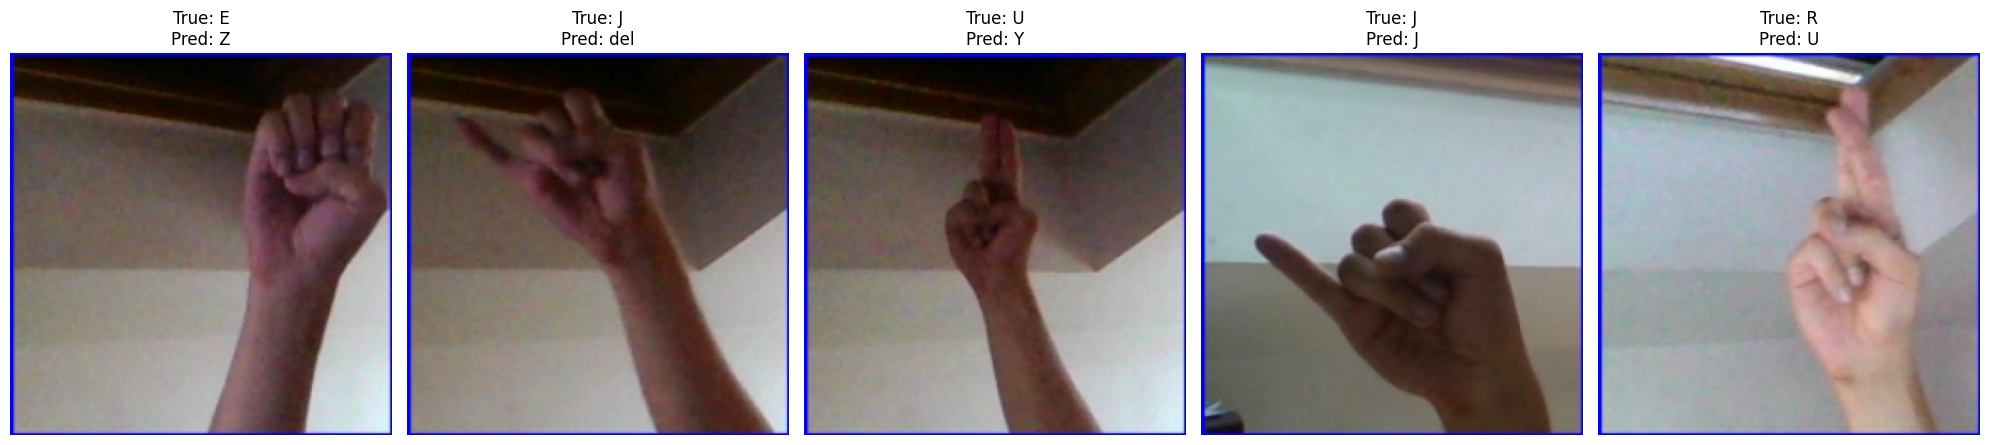

In [18]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

train_model(model, train_loader, criterion, optimizer, num_epochs=1)

evaluate_model(model, test_loader)

visualize_predictions(model, test_dataset, class_names, num_samples=5)

Сверточная модель получилась слишком хорошей, и ее улучшать не будем, улучшим бейзлайн трансформенной модели.

Флоу улучшения:
- Увеличить число эпох
- Заморозка части слоев
- Замена оптимизатора
- Mixed Precision

Итоговая цель в основном не увеличение точности, а ускорение с ее сохранением, а после - увеличение числа эпох. Ставка на том, что для модели количество эпох важнее, чем ее комплексность.

<ipython-input-19-a017300771dc>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/2175 [00:00<?, ?it/s]<ipython-input-19-a017300771dc>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 2175/2175 [07:16<00:00,  4.98it/s]


Test Accuracy: 99.87%
Hamming Loss: 0.0013
F1 Score (Macro): 0.9987
F1 Score (Weighted): 0.9987
Mean Average Precision (mAP): 1.0000


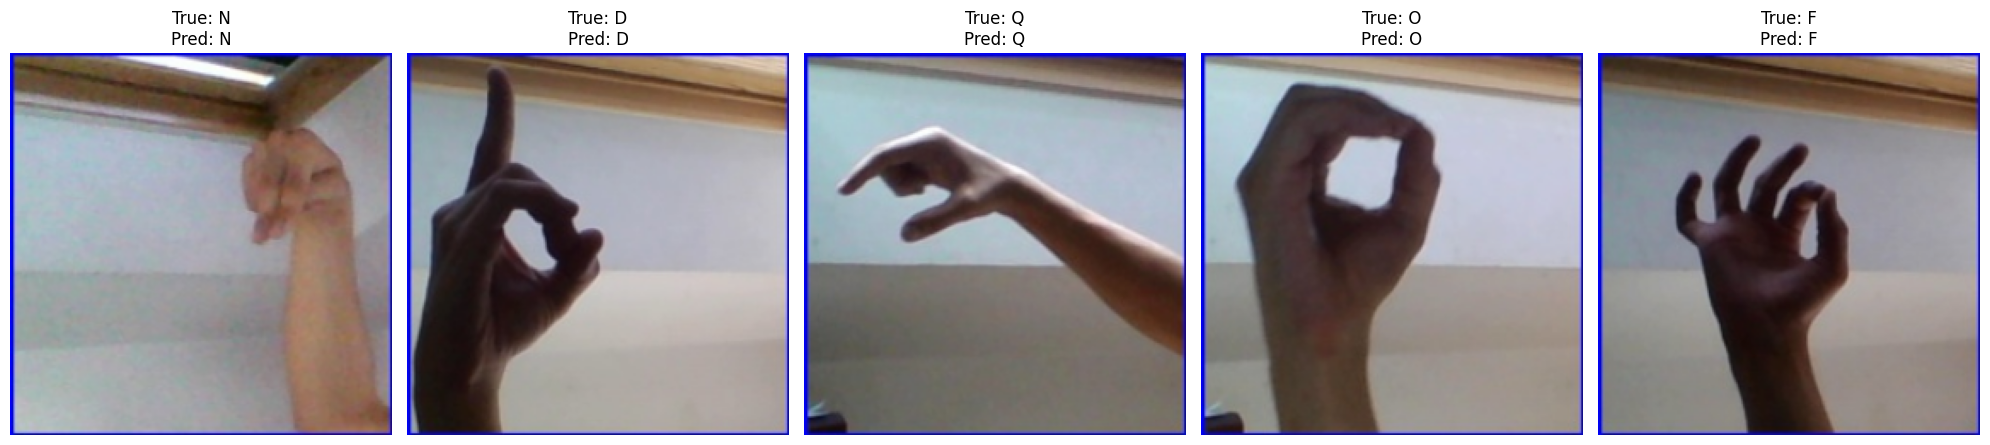

In [19]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

model = model.to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model.heads.parameters():
    param.requires_grad = True
for param in model.encoder.layers[-4:].parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

train_model(model, train_loader, criterion, optimizer, num_epochs=3)

evaluate_model(model, test_loader)

visualize_predictions(model, test_dataset, class_names, num_samples=5)

Самостоятельная имплементация сверточной модели

  0%|          | 0/2175 [00:00<?, ?it/s]<ipython-input-19-a017300771dc>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 2175/2175 [03:46<00:00,  9.58it/s]


Test Accuracy: 99.25%
Hamming Loss: 0.0075
F1 Score (Macro): 0.9926
F1 Score (Weighted): 0.9925
Mean Average Precision (mAP): 0.9996


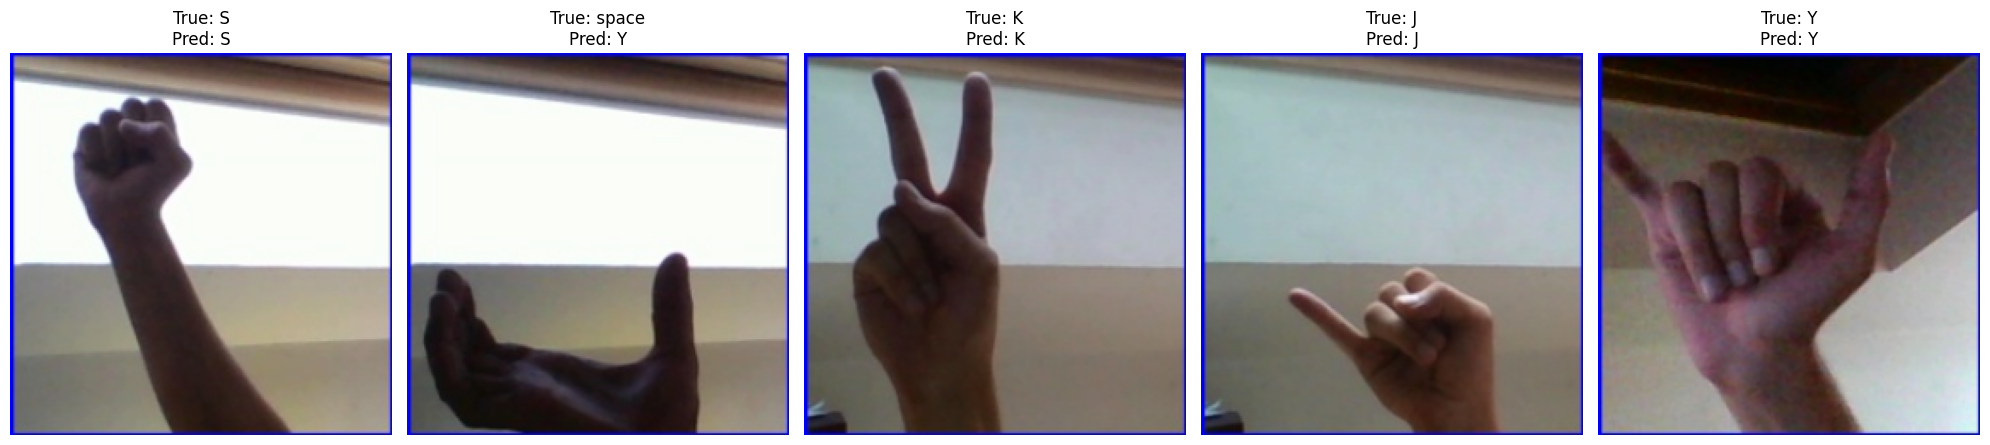

In [26]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=29):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 25 * 25, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        self.features.add_module("adaptive_pool", nn.AdaptiveAvgPool2d((25, 25)))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = CustomCNN(num_classes=len(class_names)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, num_epochs=3)
evaluate_model(model, test_loader)
visualize_predictions(model, test_dataset, class_names)

Самостоятельная имплементация трансформенной модели

In [34]:
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size=200, patch_size=20, num_classes=29,
                 dim=256, depth=6, heads=8, mlp_dim=512):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size

        self.patch_embed = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=mlp_dim,
            activation=F.gelu,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, depth)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x)
        x = x.flatten(2).permute(0, 2, 1)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed

        x = self.transformer(x)
        return self.mlp_head(x[:, 0])

model = CustomVisionTransformer(
    img_size=224,
    patch_size=28,
    num_classes=len(class_names),
    dim=192,
    depth=4,
    heads=3,
    mlp_dim=384
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
train_model(model, train_loader, criterion, optimizer, num_epochs=3)
evaluate_model(model, test_loader)

  0%|          | 0/2175 [00:00<?, ?it/s]<ipython-input-19-a017300771dc>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 2175/2175 [03:44<00:00,  9.68it/s]


Test Accuracy: 85.29%
Hamming Loss: 0.1471
F1 Score (Macro): 0.8519
F1 Score (Weighted): 0.8519
Mean Average Precision (mAP): 0.9378


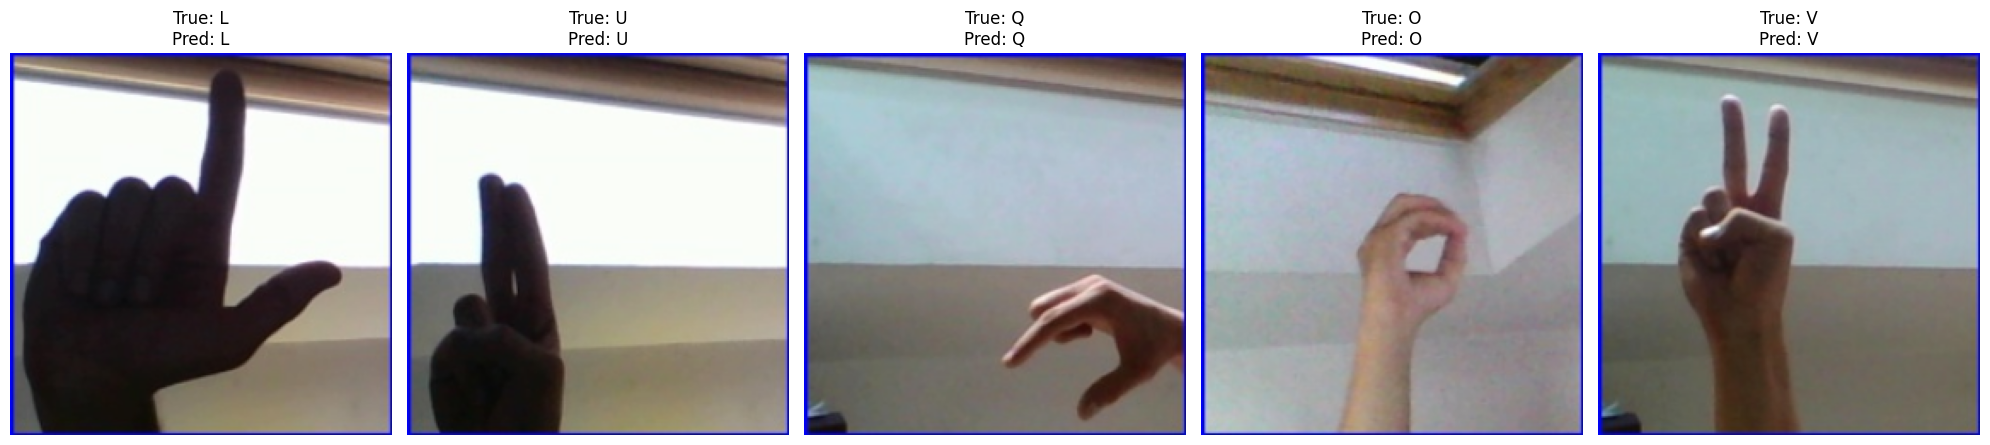

In [35]:
visualize_predictions(model, test_dataset, class_names)

Выводы:

- Сверточные модели показали хороший результат. Настолько, что им не понадобился улучшенный бейзлайн.
- Трансформенные модели могут показать результат лучше, чем сверточные, но при этом их обучение очень долгое и дорогое. Даже с сокращением 3/4 слоев, на том же количестве эпох, что и сверточные модели, результат практически абсолютный.
- Улучшенный бейзлайн оказался лишь урезанием мощности для трансформенной модели, чтобы она могла работать не по 40 минут на эпоху.
- Самостоятельные имплементации на уровне, но хуже.
- Задача для данных моделей слишком простая, давая нормальные условия результаты почти всегда близки к 100%.